## Retrieval

Retrival is the 4th stage of the pipeline. It's a process to find relevant informations from the knowledge store (could be vector database, or document database), then feed them into the next stage of the pipeline.


There are some techniques that could be used in this phrase, such as:
### Query-optimize:
Naive retrieval, retrive documents based on the question directly. 

Hypothetical Document Embeddings (HyDE), use model to generate `hypothetical answers` then retrive similar documents based on the hypothetical answers.

![hyde.png](./public/hyde.png)

[reference: Enhancing RAG with Hypothetical Document Embedding](https://www.analyticsvidhya.com/blog/2024/04/enhancing-rag-with-hypothetical-document-embedding/)



Multi-Query Retriever, use model to reword the question into multiple questions, then retrive documents based on these questions.  
![multi-query.png](./public/multi-query.png)

[reference: 3 Query Expansion Methods Implemented Using Langchain to Improve Your RAG](https://levelup.gitconnected.com/3-query-expansion-methods-implemented-using-langchain-to-improve-your-rag-81078c1330cd)

### Retrieval-optimize:
Maximal Marginal Relevant (MMR), use model to select the most relevant documents based on the question.

![mmr.png](./public/mmr.png)
[reference: RAG:MMR Search in Langchain](https://www.kaggle.com/code/marcinrutecki/rag-mmr-search-in-langchain)


Contextual compression, use model to decide which documents are related to the question.

![contextual-compression.png](./public/contextual-compression.png)

[reference: How To Optimize Your RAG Pipelines](https://newsletter.theaiedge.io/p/how-to-optimize-your-rag-pipelines)
  

In the context of this hands-on, we will try different technique to optimize Query and Retrieval.
Then compared the performance of these two techniques.

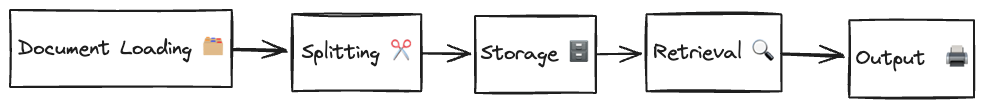

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv(".env")

# these variables are required to initialize Langchain AzureChatOpenAI instance
required_env_vars = [
    "AZURE_OPENAI_API_KEY",
    "AZURE_OPENAI_API_VERSION",
    "AZURE_OPENAI_ENDPOINT",
    "AZURE_OPENAI_MODEL",
    "AZURE_OPENAI_DEPLOYMENT_NAME",
    "AZURE_OPENAI_EMBEDDING_MODEL",
    "AZURE_OPENAI_EMBEDDING_DEPLOYMENT_NAME",
]

for var in required_env_vars:
    if os.environ.get(var) is None:
        raise Exception(f"Missing `{var}` environment variable")


api_key = os.environ.get("AZURE_OPENAI_API_KEY", "")
api_version=os.environ.get("AZURE_OPENAI_API_VERSION", "2023-03-15-preview")
azure_endpoint=os.environ.get("AZURE_OPENAI_ENDPOINT", "https://public-api.grabgpt.managed.catwalk-k8s.stg-myteksi.com")
deployment_name=os.environ.get("AZURE_OPENAI_DEPLOYMENT_NAME", "gpt-4-turbo")
model=os.environ.get("AZURE_OPENAI_MODEL", "gpt-4-turbo")
embedding_model=os.environ.get("AZURE_OPENAI_EMBEDDING_MODEL", "text-embedding-3-large")
embedding_deployment_name=os.environ.get("AZURE_OPENAI_EMBEDDING_DEPLOYMENT_NAME", "text-embedding-3-large")

In [ ]:
from typing import Dict, Any, List
from langchain.callbacks.base import BaseCallbackHandler

class LoggingHandler(BaseCallbackHandler):
    def on_chain_start(
        self, serialized: Dict[str, Any], inputs: Dict[str, Any], **kwargs
    ) -> None:
        print(f"Chain {serialized.get('name')} started")

    def on_chain_end(self, outputs: Dict[str, Any], **kwargs) -> None:
        print(f"Chain ended, outputs: {outputs}")

In [ ]:
from langchain.prompts import ChatPromptTemplate
from langchain.docstore.document import Document
from langchain.pydantic_v1 import BaseModel, Field
from langchain.chat_models import AzureChatOpenAI

from langchain_core.output_parsers import JsonOutputParser
from langchain_core.runnables import RunnableSequence

VALIDATE_SYSTEM_PROMPT = """
You are an expert in evaluating document. You will be given a query and a document content. Your task is to evaluate if the document's content is related to the query. Provide a confidence score for the evaluation.

query: {query}
document content: {document_content}

{format_instruction}\n
"""

class ResponseModel(BaseModel):
    confidence: int = Field(
        description="score of the evaluation, higher score means higher confidence in the evaluation, value must be from 0 to 5"
    )
    related: bool = Field(
        description="evaluate if the document's content is related to the query"
    )


llm = AzureChatOpenAI(
    api_key=api_key,
    api_version=api_version,
    azure_deployment=deployment_name,
)


def validate_candidate(query: str, document: Document) -> ResponseModel:
    parser = JsonOutputParser(pydantic_object=ResponseModel)

    validate_prompt = ChatPromptTemplate.from_messages(
        messages=[
            ("system", VALIDATE_SYSTEM_PROMPT),
        ]
    ).partial(format_instruction=parser.get_format_instructions())

    validate_chain = RunnableSequence(
        validate_prompt,
        llm,
        parser,
    )
    response = validate_chain.invoke(
        {"query": query, "document_content": document.page_content}
    )
    return response

In [ ]:
from langchain.vectorstores import Chroma
from langchain.embeddings import AzureOpenAIEmbeddings

embedding = AzureOpenAIEmbeddings(
    api_key=api_key,
    api_version=api_version,
    azure_deployment=embedding_deployment_name,
)

persist_directory = "./docs/chroma"
vectordb = Chroma(
    persist_directory=persist_directory,
    embedding_function=embedding,
)
vectordb._collection.count()

### Query-optimize:
In the context of this hands-on, we will try `naive query`, `Hypothetical Document Embeddings (HyDE)` and `Multi-Query` techniques to optimize the query.

In [ ]:
from langchain_core.runnables import RunnableSequence, RunnablePassthrough

naive_prompt_chain = lambda x: x["input"]

retriever_chain = RunnableSequence(
    vectordb.as_retriever(),
    {"candidates": RunnablePassthrough()}
)

### Naive query
In this technique, the RAG model will pass the question directly to the retriever to find the relevant documents

In [ ]:
naive_query_retriever_chain = RunnableSequence(
    naive_prompt_chain,
    retriever_chain,
).with_config(callbacks=[LoggingHandler()])

question = "How to resolve Fail to push image error while running cop_image:envoy-base stage in ci/cd pipeline?"
response = naive_query_retriever_chain.invoke({"input": question})
for candidate in response["candidates"]:
    validate_response = validate_candidate(query=question, document=candidate)
    print(validate_response)
    print(candidate.metadata)
    print(candidate.page_content[:1000])



### Hypothetical Document Embeddings (HyDE)

In this technique, the RAG model will generate hypothetical answers (using LLM), then the retriever will find the relevant documents based on these hypothetical answers.

In [ ]:
from langchain.prompts import ChatPromptTemplate

from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableSequence

HYDE_SYSTEM_PROMPT = """
Use your expertise to answer the following question. Provide a brief answer to the question, the answer should be concise and informative and contains all important keywords.
"""

hyde_prompt = ChatPromptTemplate.from_messages(
    messages=[
        ("system", HYDE_SYSTEM_PROMPT),
        ("user", "{input}"),
    ]
)

llm = AzureChatOpenAI(
    api_key=api_key,
    api_version=api_version,
    azure_deployment=deployment_name,
)
hyde_prompt_chain = RunnableSequence(
    hyde_prompt,
    llm,
    StrOutputParser(),
)

In [ ]:
from langchain.globals import set_verbose

hyde_retriever_chain = RunnableSequence(
    hyde_prompt_chain,
    retriever_chain,
).with_config(callbacks=[LoggingHandler()])

question = "How to resolve Fail to push image error while running cop_image:envoy-base stage in ci/cd pipeline?"
response = hyde_retriever_chain.invoke({"input": question})
for candidate in response["candidates"]:
    validate_response = validate_candidate(query=question, document=candidate)
    print(validate_response)
    print(candidate.metadata)
    print(candidate.page_content[:1000])

set_verbose(False)


### Multi-Query

In this technique, the RAG model will reword the question into multiple questions, then the retriever will find the relevant documents based on these questions.

In [ ]:
from langchain.prompts import ChatPromptTemplate
from langchain.pydantic_v1 import BaseModel, Field

from langchain_core.output_parsers import JsonOutputParser

MULTI_QUERY_SYSTEM_PROMPT = """
Rewrite the following question into 3 different question, each question must have the same meaning as the original question. Don't change the meaning of the question.

{format_instruction}
"""

class MultiQueryResponseModel(BaseModel):
    questions: List[str] = Field(description="list of rewritten questions")

parser = JsonOutputParser(pydantic_object=MultiQueryResponseModel)

multi_query_prompt = ChatPromptTemplate.from_messages(
    messages=[
        ("system", MULTI_QUERY_SYSTEM_PROMPT),
        ("user", "{input}"),
    ],
).partial(format_instruction=parser.get_format_instructions())

llm = AzureChatOpenAI(
    api_key=api_key,
    api_version=api_version,
    azure_deployment=deployment_name,
)

multi_query_prompt_chain = RunnableSequence(
    multi_query_prompt,
    llm,
    parser,
)

In [ ]:
from langchain_core.runnables import RunnableLambda

multi_query_retriever_chain = RunnableSequence(
    multi_query_prompt_chain,
    # output of previous chain is a list of questions, now, retrieve documents for each question
    RunnableLambda(
        (
            lambda x: [
                retriever_chain.invoke(x["questions"][i])
                for i in range(len(x["questions"]))
            ]
        )
    ),
).with_config(callbacks=[LoggingHandler()])

question = "How to resolve Fail to push image error while running cop_image:envoy-base stage in ci/cd pipeline?"
response = multi_query_retriever_chain.invoke({"input": question})
for query in response:
    for candidate in query["candidates"]:
        validate_response = validate_candidate(query=question, document=candidate)
        print(validate_response)
        print(candidate.metadata)
        print(candidate.page_content[:1000])


### Retrieval-optimize

In the context of this hands-on, we will try the `naive retrieval` and ` Maximal Marginal Relevant (MMR)` techniques to optimize the retrieval.

### Naive retrieval

In [ ]:
from langchain_core.runnables import RunnableSequence, RunnablePassthrough, RunnablePick

naive_retriever = RunnableSequence(
    RunnablePick("input"),
    vectordb.as_retriever(),
    {"candidates": RunnablePassthrough()}
)

In [ ]:
question = "How to resolve Fail to push image error while running cop_image:envoy-base stage in ci/cd pipeline?"
response = naive_retriever.invoke({"input": question})

In [ ]:
for candidate in response["candidates"]:
    validate_response = validate_candidate(query=question, document=candidate)
    print(validate_response)
    candidate.metadata

### Maximal Marginal Relevant (MMR)

In [ ]:
mmr_retriever = RunnableSequence(
    RunnablePick("input"),
    vectordb.as_retriever(
        search_type="mmr", search_kwargs={"k": 4, "lambda_mult": 0.25}
    ),
    {"candidates": RunnablePassthrough()},
)

In [ ]:
mmr_response = mmr_retriever.invoke({"input": question})

In [ ]:
for candidate in mmr_response["candidates"]:
    validate_response = validate_candidate(query=question, document=candidate)
    print(validate_response)
    print(candidate.metadata)